# Pytorch Workflow

In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt 

# Check Pytorch version
torch.__version__

'2.3.0+cu121'

# 1. Data (Preparing and loading)

* Excel speadsheet
* Image of any kind
* Videos
* Audios
* DNA
* Text

Machine Learning is a game of two parts:

1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

In [15]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create a data
start = 0 
end = 1
step = 0.02 
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [16]:
# Create a train/test split 
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train),  len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [17]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test, 
                    predictions=None):
    """
    Plot training data , test data and compare predictions.
    """
    plt.figure(figsize=(10,7))
    plt.scatter(train_data,train_labels, c='b',s=4, label="Training data")
    plt.scatter(test_data,test_labels, c='g',s=4, label="Testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions,c='r', s=4,label="Predictions")
    plt.legend(prop={"size":14});

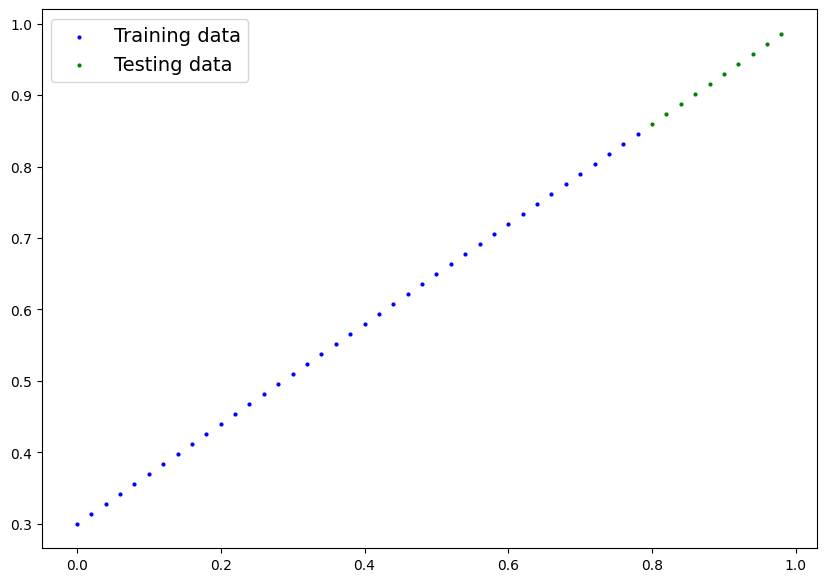

In [18]:
plot_prediction()

In [19]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4090 Laptop GPU


In [20]:
import torch
from torch import nn
# Create linear regression model class
class LinearRegressionModel(nn.Module):  # almost everything in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, # Start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # can this parameter be updated via gradient descent
                                            dtype=torch.float # PyTorch like the datatype torch.float32
                                            ))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self,x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (neural network).
* torch.nn.Parameter - what parameters  should model try and learn, often a PyTorch layer from torch.nn will set these for us.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Module  subclasses require you to overwrite forward(), this method defines what happends in the forward computation.


### Checking contents of PyTorch model

To check what;s inside model we use `.parameters()`

In [21]:
# Create a random seed(42)
torch.manual_seed(42)
# Create an instance of the modal (this is subclass of nn.Module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [22]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

When we pass data through our model, it's going to run it through the `forward()` method.

In [24]:
# Make prediction with model 
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

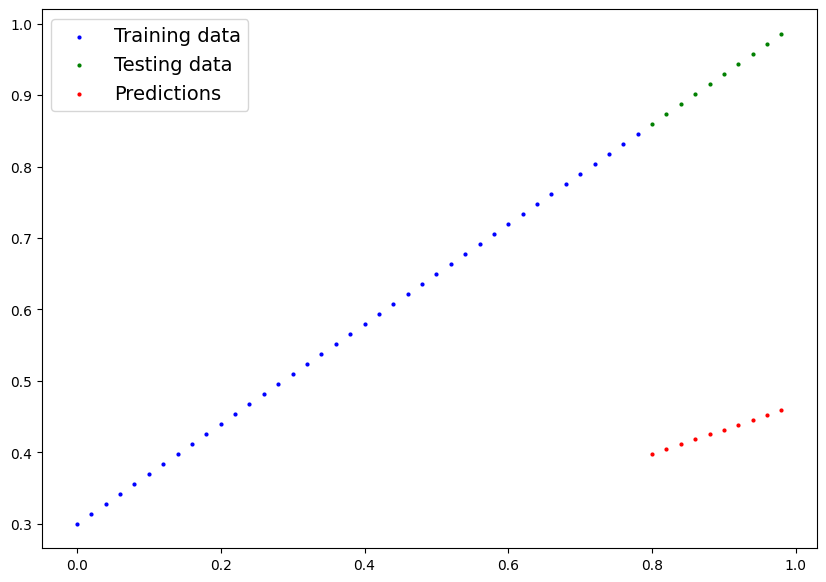

In [25]:
plot_prediction(predictions=y_preds)

## 3. Train model

One way to measure how wrong model predictions are we can use the loss function.

* Note: Loss function is also called as the cost function or criterion in different area.

Things we need to train:

* **Lost function**: A function to measure how wrong model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. wight & bias in our case) to improve the loss function.

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [26]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [27]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [28]:
# Setup a loss function 
loss_fn = nn.L1Loss()
# Setup a optimizer function (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Building a training loop (and a testing loop) in PyTorch

Things we need in a training loop:

1. Loop through the data
2. Forward pass (this involves data moving through our model's `forward()` function) to make predictions- also called forward propagation
3. Calculate the loss (compare forward pass predictions to hround truth labels)
4. Optimizer zero grad
5. Loss backward - move backward through the network to calculate the gradients of each of the parameters of model wrt loss (**backpropogation**)
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [29]:
torch.manual_seed(42)
epochs = 200
epoch_count = []
loss_values = []
test_loss_values = []
### Training 
#1. Loop through the data 
for epoch in range(epochs):
    model_0.train()
    # 1. Forward pass 
    y_pred = model_0(X_train)
    # 2. Calculate the loss 
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()
    # 4. Perform backprogation 
    loss.backward()
    # 5. Step 
    optimizer.step()
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0(X_test)
        # 2. Calculate the loss 
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epochs: {epoch} | loss : {loss} | Test Loss: {test_loss}")
        # Print out model state_dict()
        print(model_0.state_dict())

Epochs: 0 | loss : 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epochs: 10 | loss : 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epochs: 20 | loss : 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epochs: 30 | loss : 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epochs: 40 | loss : 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epochs: 50 | loss : 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epochs: 60 | loss : 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})
Epochs: 

In [30]:
import numpy as np 
np.array(torch.tensor(loss_values).cpu().numpy()), test_loss_values

(array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
        0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
        0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.4811),
  tensor(0.3464),
  tensor(0.2173),
  tensor(0.1446),
  tensor(0.1136),
  tensor(0.0992),
  tensor(0.0889),
  tensor(0.0806),
  tensor(0.0723),
  tensor(0.0647),
  tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

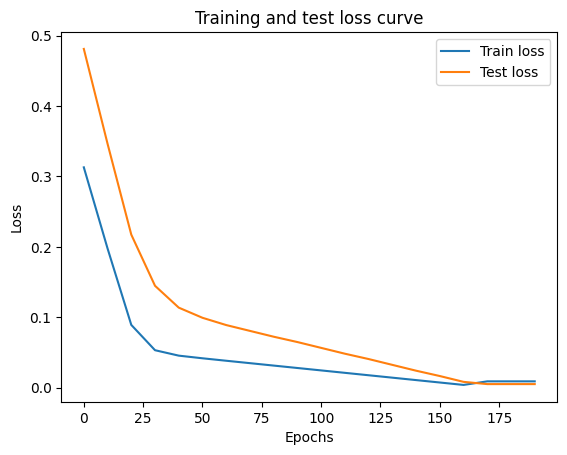

In [32]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [33]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

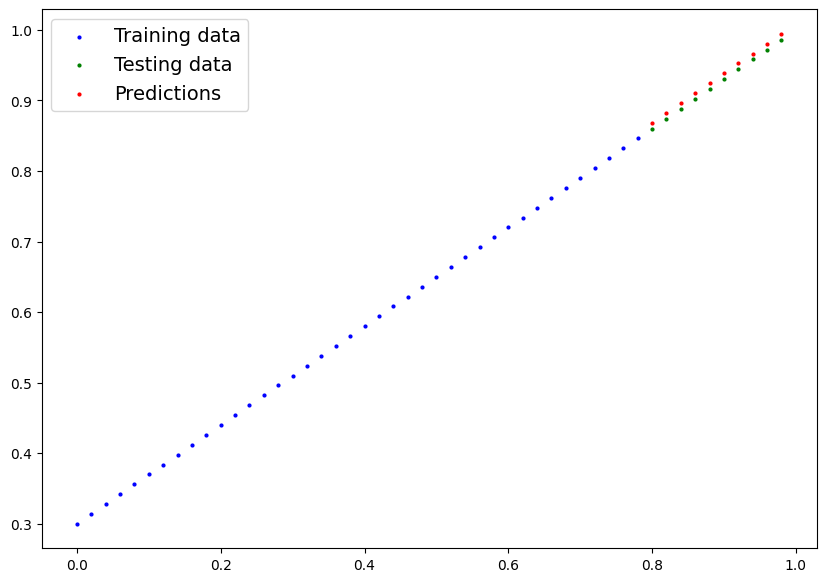

In [34]:
plot_prediction(predictions=y_preds_new)

## Saving model in PyTorch

There are three main methods for saving and loading models in PyTorch.

1. `torch.save()` - allows to save a PyTorch object in Python's pickle format.
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load model's saved state dictionary

In [35]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [40]:
# Save PyTorch model 
from pathlib import Path 
# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
# 2. Create model save path 
MODEL_NAME = "01_pytorch_regression_model0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
# 3. Save the model 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_regression_model0.pth


## Loading a PyTorch model

In [42]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [43]:
# Load the model 
loaded_model_0 = LinearRegressionModel()
# Load the saved state_dict of model_0 
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [44]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [45]:
# Make predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [46]:
# Make predictions with model 
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [47]:
# Compare loaded model preds with original model preds
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [49]:
# Importing libraries 
import torch
from torch import nn
import matplotlib.pyplot as plt 
# Check PyTorch version
torch.__version__

'2.2.2+cu121'

Create device-agnostic code.

if GPU acess is available code use it for faster computing else code will use CPU.

In [50]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [54]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 4090 Laptop GPU'

### 6.1 Data

In [55]:
# Create some data using linear regression formula of y = weight * X + bias
weight = 0.7 
bias = 0.3
# Create range values 
start = 0 
end = 1
step = 0.02
# Create X and y (features and label)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 
X[:10], y[:10] 

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [56]:
# Split data 
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

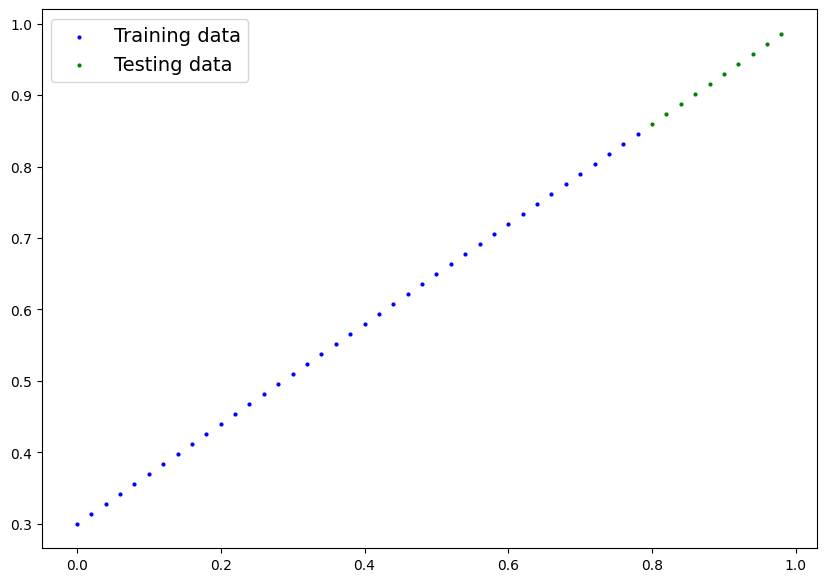

In [57]:
# Plot the data 
plot_prediction()

### 6.2 Building a PyTorch Linear model

In [61]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  def forward(self,x:torch.Tensor)-> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [62]:
# Check the model current device 
next(model_1.parameters()).device

device(type='cpu')

In [63]:
# Set the model to use the target device 
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [64]:
# Setup the loss function 
loss_fn = nn.L1Loss()
# Setup the optimizer 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [65]:
# training loop 
torch.manual_seed(42)
epochs = 200
# Put the data on the target device (device agnoistic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
for epoch in range(epochs):
    model_1.train()
    # 1. Forward pass 
    y_pred = model_1(X_train)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # 3. Optimizer zero grad 
    optimizer.zero_grad()
    # 4. perform backpropogation
    loss.backward()
    # 5. Optimizer step
    optimizer.step()
    ### Testing 
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
    # Print out whats happening 
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

### 6.4 Making and evaluating predictions

In [66]:
# Turn model into evaluation model 
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

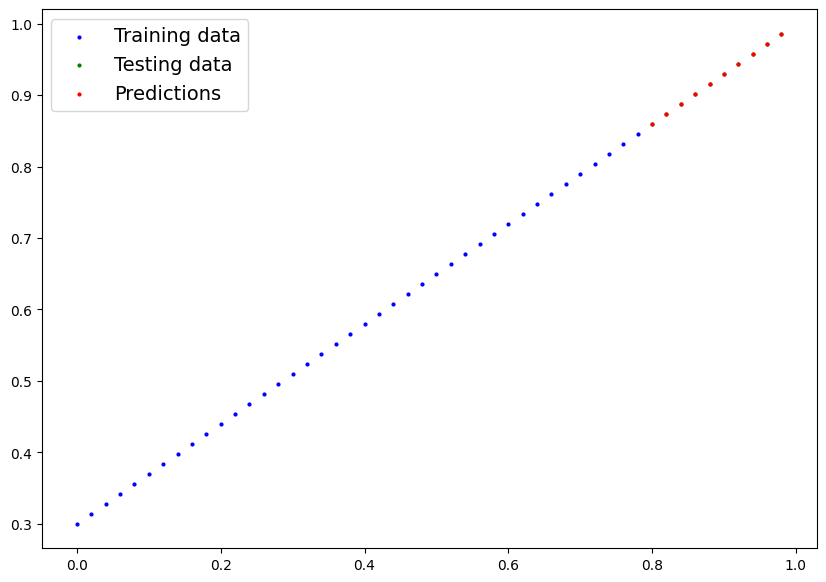

In [67]:
# Check model predictions 
plot_prediction(predictions=y_preds.cpu())

### 6.5 Saving and loading the model

In [68]:
from pathlib import Path 
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
# 2. Create model save path 
MODEL_NAME = "pytorch_regression_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
#3. Save the model 
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to : models\pytorch_regression_model_1.pth


In [69]:
# Load a model 
loaded_model_1 = LinearRegressionModelV2()
# Load saved model_1 state_dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
# Put the loaded model to device 
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [70]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [71]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [73]:
# Evaluate loaded model 
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
loaded_model_1_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

In [74]:
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')